In [164]:
library("httr2")

library("jsonlite") # Parse JSON

library("listviewer") # View Json
library("tidyverse")
library(tm)
library(wordcloud)
library(SnowballC)
library(rvest)
install.packages('pxweb')
library("pxweb")

Warning message:
"package 'pxweb' is in use and will not be installed"


Möjliga datakällor hos SCB för utbildning:
Examina
https://www.statistikdatabasen.scb.se/pxweb/sv/ssd/START__UF__UF0550__UF0550C/Historisk11bN/
Yrkesexamina
https://www.statistikdatabasen.scb.se/pxweb/sv/ssd/START__UF__UF0550__UF0550C/Historisk11b/
Utbildningsnivå
https://www.statistikdatabasen.scb.se/pxweb/sv/ssd/START__UF__UF0506__UF0506B/Utbildning/
Studiedeltagande:
https://www.statistikdatabasen.scb.se/pxweb/sv/ssd/START__UF__UF0507/StudiedeltagandeK/

In [165]:
source1<-"doris/sv/ssd/START/UF/UF0550/UF0550C/Historisk11bN"
#"https://api.scb.se/OV0104/v1/doris/%s"
URI<-sprintf("https://api.scb.se/OV0104/v1/%s",source1)
URI
json_req<-'{
  "query": [
    {
      "code": "Examen",
      "selection": {
        "filter": "item",
        "values": [
          "D",
          "E",
          "F",
          "L",
          "G"
        ]
      }
    },
    {
      "code": "Kon",
      "selection": {
        "filter": "item",
        "values": [
          "1.2",
          "1",
          "2"
        ]
      }
    }
  ],
  "response": {
    "format": "px"
  }
}'
#json_req <-stripWhitespace(json_req)
request <- request("https://api.scb.se/OV0104/v1/doris/sv/ssd/START/UF/UF0550/UF0550C/Historisk11bN")|>req_body_json(json_req)
req_dry_run(request)

[1] "https://api.scb.se/OV0104/v1/doris/sv/ssd/START/UF/UF0550/UF0550C/Historisk11bN"

POST /OV0104/v1/doris/sv/ssd/START/UF/UF0550/UF0550C/Historisk11bN HTTP/1.1
Host: api.scb.se
User-Agent: httr2/1.0.7 r-curl/6.0.1 libcurl/8.10.1
Accept: */*
Accept-Encoding: deflate, gzip
Content-Type: application/json
Content-Length: 500

"{\n  \"query\": [\n    {\n      \"code\": \"Examen\",\n      \"selection\": {\n        \"filter\": \"item\",\n        \"values\": [\n          \"D\",\n          \"E\",\n          \"F\",\n          \"L\",\n          \"G\"\n        ]\n      }\n    },\n    {\n      \"code\": \"Kon\",\n      \"selection\": {\n        \"filter\": \"item\",\n        \"values\": [\n          \"1.2\",\n          \"1\",\n          \"2\"\n        ]\n      }\n    }\n  ],\n  \"response\": {\n    \"format\": \"px\"\n  }\n}"


In [166]:
#d <- pxweb_interactive("https://api.scb.se/OV0104/v1/doris/sv/ssd/UF/UF0550/UF0550C/Historisk11bN")
pxweb_query_list <-
  list(
    "Examen" = c("*"), # Use "*" to select all
    "Kon" = c("*"),
    "ContentsCode" = c("000004NE"),
    "Tid" = c("*")
  )

pxq<-pxweb_query_list
pxg<-pxweb_get("https://api.scb.se/OV0104/v1/doris/sv/ssd/START/UF/UF0550/UF0550C/Historisk11bN",pxq)

In [167]:
df<-as.data.frame(pxg)
df<-as_tibble(df)
#head(df)
#df<-
filtered_df_doktor<-df%>%filter(examen %in% c("Doktorsgrad","Doktorsexamen"))

summarized_df_doktor<- filtered_df_doktor %>%
  group_by(läsår,kön) %>%
  summarize(`Utfärdade examina vid universitet och högskolor` = sum(`Utfärdade examina vid universitet och högskolor`),.groups = "drop") %>%
  mutate(examen = 'Summed Doktorsgrad/Doktorsexamen')

filtered_df_licenciat<-df%>%filter(examen %in% c("Licentiatexamen","Licentiatexamen (Äldre)"))

summarized_df_licenciat<- filtered_df_licenciat %>%
  group_by(läsår,kön) %>%
  summarize(`Utfärdade examina vid universitet och högskolor` = sum(`Utfärdade examina vid universitet och högskolor`),.groups = "drop") %>%
  mutate(examen = 'Summed Licenciatexamen/Licentiatexamen (Äldre)')

# Remove the original rows from the DataFrame
df <- df %>% filter(!examen %in% c('Doktorsgrad', 'Doktorsexamen',"Licentiatexamen","Licentiatexamen (Äldre)"))

# Append the summarized rows to the DataFrame
df <- bind_rows(df, summarized_df_doktor,summarized_df_licenciat)

#df<-df%>%mutate(examen=str_replace_all(examen,"(Doktor).*","Doktorsexamen(& Grad)"))%>%group_by(examen)
#df%>%select(examen,läsår)%>%unique()
#df

examen,år,båda könen,män,kvinnor
<chr>,<int>,<dbl>,<dbl>,<dbl>
Examen från grundutbildning,1936,2024,1637,387
Examen från grundutbildning,1937,2265,1847,418
Examen från grundutbildning,1938,2210,1811,399
Examen från grundutbildning,1939,1943,1473,470
Examen från grundutbildning,1940,2132,1617,515
Examen från grundutbildning,1941,2372,1830,542
Examen från grundutbildning,1942,2262,1698,564
Examen från grundutbildning,1943,2406,1838,568
Examen från grundutbildning,1944,2493,1889,604


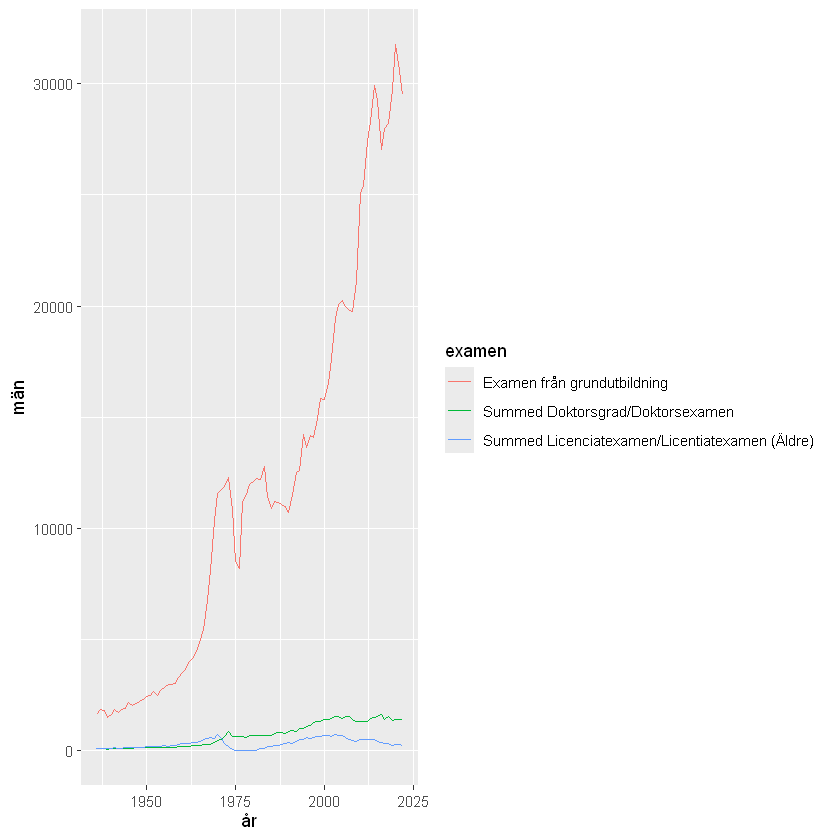

In [168]:
education_df<-df%>%pivot_wider(names_from=kön,values_from = `Utfärdade examina vid universitet och högskolor`)%>%mutate(läsår=as.integer(str_extract(läsår,"^\\w*")))%>%rename(år=läsår)

#test_df<-test_df%>%mutate(examen=str_replace_all(examen,"(Doktor).*","Doktorsexamen(& Grad)"))


education_df
ggplot(data=education_df,mapping=aes(x=år))+geom_line(mapping=aes(x=år,y=män,color=examen))

In [169]:


pxweb_query_list <-
  list(
    "Kon" = c("*"),
    "ContentsCode" = c("000000LV"),
    "Tid" = c("*")
  )

pxq<-pxweb_query_list
pxg<-pxweb_get("https://api.scb.se/OV0104/v1/doris/sv/ssd/START/BE/BE0101/BE0101G/BefUtvKon1749",pxq)


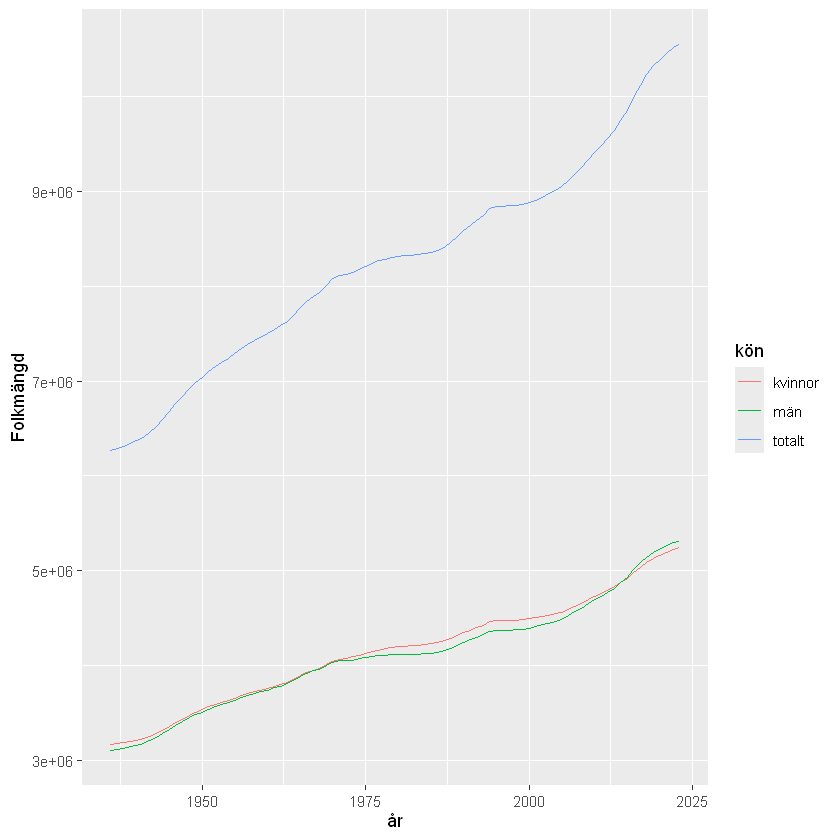

In [170]:
population_df<-as.data.frame(pxg)
population_df<-as_tibble(population_df)%>%filter(år>=1936)%>%mutate(år=as.integer(år))

ggplot(data=population_df,mapping=aes(x=år))+geom_line(mapping=aes(y=`Folkmängd`,color=kön))
population_df<-population_df%>%pivot_wider(names_from = kön,values_from = `Folkmängd`,names_prefix = "folkmängd_")%>%mutate(år=as.integer(år))

In [173]:
joined_df<-education_df%>%left_join(y=population_df,by=join_by(år))%>%mutate(andel_män=`folkmängd_män`/`folkmängd_totalt`,andel_kvinnor=`folkmängd_kvinnor`/`folkmängd_totalt`)
head(joined_df)

examen,år,båda könen,män,kvinnor,folkmängd_män,folkmängd_kvinnor,folkmängd_totalt,andel_män,andel_kvinnor
<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Examen från grundutbildning,1936,2024,1637,387,3100534,3166354,6266888,0.4947486,0.5052514
Examen från grundutbildning,1937,2265,1847,418,3111256,3173466,6284722,0.4950507,0.5049493
Examen från grundutbildning,1938,2210,1811,399,3125000,3185214,6310214,0.4952288,0.5047712
Examen från grundutbildning,1939,1943,1473,470,3142356,3198947,6341303,0.4955379,0.5044621
Examen från grundutbildning,1940,2132,1617,515,3160128,3211304,6371432,0.4959839,0.5040161
Examen från grundutbildning,1941,2372,1830,542,3180535,3225939,6406474,0.4964564,0.5035436


In [177]:
mlr_df<-joined_df%>%select(examen,år,`båda könen`,män,kvinnor,`folkmängd_totalt`,`folkmängd_män`,`folkmängd_kvinnor`)
head(mlr_df)
test_model<-lm(`båda könen`~`folkmängd_totalt`+`år`,data=mlr_df%>%filter(examen=="Summed Doktorsgrad/Doktorsexamen"))
summary(test_model)

examen,år,båda könen,män,kvinnor,folkmängd_totalt,folkmängd_män,folkmängd_kvinnor
<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Examen från grundutbildning,1936,2024,1637,387,6266888,3100534,3166354
Examen från grundutbildning,1937,2265,1847,418,6284722,3111256,3173466
Examen från grundutbildning,1938,2210,1811,399,6310214,3125000,3185214
Examen från grundutbildning,1939,1943,1473,470,6341303,3142356,3198947
Examen från grundutbildning,1940,2132,1617,515,6371432,3160128,3211304
Examen från grundutbildning,1941,2372,1830,542,6406474,3180535,3225939



Call:
lm(formula = `båda könen` ~ folkmängd_totalt + år, data = mlr_df %>% 
    filter(examen == "Summed Doktorsgrad/Doktorsexamen"))

Residuals:
    Min      1Q  Median      3Q     Max 
-641.65 -216.77   32.13  231.15  585.46 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)      -1.489e+05  1.496e+04  -9.954 7.18e-16 ***
folkmängd_totalt -9.367e-04  1.911e-04  -4.901 4.58e-06 ***
år                7.970e+01  8.340e+00   9.557 4.50e-15 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 313.9 on 84 degrees of freedom
Multiple R-squared:  0.9135,	Adjusted R-squared:  0.9114 
F-statistic: 443.4 on 2 and 84 DF,  p-value: < 2.2e-16


https://api.scb.se/OV0104/v1/doris/sv/ssd/START/HE/HE0110/HE0110A/NetInk02


{
  "query": [
    {
      "code": "Region",
      "selection": {
        "filter": "vs:RegionRiket99",
        "values": [
          "00"
        ]
      }
    },
    {
      "code": "Kon",
      "selection": {
        "filter": "item",
        "values": [
          "1",
          "2",
          "1+2"
        ]
      }
    },
    {
      "code": "Alder",
      "selection": {
        "filter": "vs:Ålder4gr",
        "values": [
          "20+"
        ]
      }
    },
    {
      "code": "ContentsCode",
      "selection": {
        "filter": "item",
        "values": [
          "000001OR"
        ]
      }
    }
  ],
  "response": {
    "format": "px"
  }
}

In [178]:
pxweb_query_list<-list(
  "Region" = c("00"),
  "Kon" = c("*"),
  "Alder"=c("20+"),#16+ eller 20+???
  "ContentsCode" = c("000001OR")
)
pxq<-pxweb_query_list
pxg<-pxweb_get("https://api.scb.se/OV0104/v1/doris/sv/ssd/START/HE/HE0110/HE0110A/NetInk02",pxq)

Warning message:
"Missing mandatory variable(s): 'Tid'. 
All values are requested in query."


In [179]:
avg_income_df<-as.data.frame(pxg)
avg_income_df<-as_tibble(avg_income_df)

In [180]:
avg_income_df

region,kön,ålder,år,"Medelinkomst, tkr"
<chr>,<chr>,<chr>,<chr>,<dbl>
Riket,män,20+ år,2000,175.4
Riket,män,20+ år,2001,171.7
Riket,män,20+ år,2002,177.8
Riket,män,20+ år,2003,182.0
Riket,män,20+ år,2004,190.4
Riket,män,20+ år,2005,202.2
Riket,män,20+ år,2006,217.3
Riket,män,20+ år,2007,239.2
Riket,män,20+ år,2008,239.7


In [181]:
#https://api.scb.se/OV0104/v1/doris/sv/ssd/START/HE/HE0103/HE0103A/ArbInk28
pxweb_query_list<-list(

  "Kon" = c("*"),
  "Tid" = c("*"),
  "ContentsCode" = c("HE0103CL")
          #"HE0103CM")
)

pxq<-pxweb_query_list
pxg<-pxweb_get("https://api.scb.se/OV0104/v1/doris/sv/ssd/START/HE/HE0103/HE0103A/ArbInk28",pxq)
avg_income_df2<-as.data.frame(pxg)
avg_income_df2<-as_tibble(avg_income_df2)%>%filter(år>=1936)%>%mutate(år=as.integer(år))
summary(avg_income_df2)

     kön                  år       Medelvärde, tkr
 Length:108         Min.   :1975   Min.   :105.8  
 Class :character   1st Qu.:1987   1st Qu.:171.9  
 Mode  :character   Median :1996   Median :204.7  
                    Mean   :1995   Mean   :206.0  
                    3rd Qu.:2004   3rd Qu.:236.9  
                    Max.   :2013   Max.   :317.2  

Kolla multipel linjär regression med inkomst antal personer och möjligtvis år

data om kpi
https://api.scb.se/OV0104/v1/doris/sv/ssd/START/PR/PR0101/PR0101A/KPItotM 

{
  "query": [
    {
      "code": "ContentsCode",
      "selection": {
        "filter": "item",
        "values": [
          "000004VU",
          "000004VT"
        ]
      }
    },
    {
      "code": "Tid",
      "selection": {
        "filter": "item",
        "values": [
          "2000M01",
          "2000M02",
          "2000M03",
          "2000M04",
          "2000M05",
          "2000M06",
          "2000M07",
          "2000M08",
          "2000M09",
          "2000M10",
          "2000M11",
          "2000M12",
          "2001M01",
          "2001M02",
          "2001M03",
          "2001M04",
          "2001M05",
          "2001M06",
          "2001M07",
          "2001M08",
          "2001M09",
          "2001M10",
          "2001M11",
          "2001M12",
          "2002M01",
          "2002M02",
          "2002M03",
          "2002M04",
          "2002M05",
          "2002M06",
          "2002M07",
          "2002M08",
          "2002M09",
          "2002M10",
          "2002M11",
          "2002M12",
          "2003M01",
          "2003M02",
          "2003M03",
          "2003M04",
          "2003M05",
          "2003M06",
          "2003M07",
          "2003M08",
          "2003M09",
          "2003M10",
          "2003M11",
          "2003M12",
          "2004M01",
          "2004M02",
          "2004M03",
          "2004M04",
          "2004M05",
          "2004M06",
          "2004M07",
          "2004M08",
          "2004M09",
          "2004M10",
          "2004M11",
          "2004M12",
          "2005M01",
          "2005M02",
          "2005M03",
          "2005M04",
          "2005M05",
          "2005M06",
          "2005M07",
          "2005M08",
          "2005M09",
          "2005M10",
          "2005M11",
          "2005M12",
          "2006M01",
          "2006M02",
          "2006M03",
          "2006M04",
          "2006M05",
          "2006M06",
          "2006M07",
          "2006M08",
          "2006M09",
          "2006M10",
          "2006M11",
          "2006M12",
          "2007M01",
          "2007M02",
          "2007M03",
          "2007M04",
          "2007M05",
          "2007M06",
          "2007M07",
          "2007M08",
          "2007M09",
          "2007M10",
          "2007M11",
          "2007M12",
          "2008M01",
          "2008M02",
          "2008M03",
          "2008M04",
          "2008M05",
          "2008M06",
          "2008M07",
          "2008M08",
          "2008M09",
          "2008M10",
          "2008M11",
          "2008M12",
          "2009M01",
          "2009M02",
          "2009M03",
          "2009M04",
          "2009M05",
          "2009M06",
          "2009M07",
          "2009M08",
          "2009M09",
          "2009M10",
          "2009M11",
          "2009M12",
          "2010M01",
          "2010M02",
          "2010M03",
          "2010M04",
          "2010M05",
          "2010M06",
          "2010M07",
          "2010M08",
          "2010M09",
          "2010M10",
          "2010M11",
          "2010M12",
          "2011M01",
          "2011M02",
          "2011M03",
          "2011M04",
          "2011M05",
          "2011M06",
          "2011M07",
          "2011M08",
          "2011M09",
          "2011M10",
          "2011M11",
          "2011M12",
          "2012M01",
          "2012M02",
          "2012M03",
          "2012M04",
          "2012M05",
          "2012M06",
          "2012M07",
          "2012M08",
          "2012M09",
          "2012M10",
          "2012M11",
          "2012M12",
          "2013M01",
          "2013M02",
          "2013M03",
          "2013M04",
          "2013M05",
          "2013M06",
          "2013M07",
          "2013M08",
          "2013M09",
          "2013M10",
          "2013M11",
          "2013M12",
          "2014M01",
          "2014M02",
          "2014M03",
          "2014M04",
          "2014M05",
          "2014M06",
          "2014M07",
          "2014M08",
          "2014M09",
          "2014M10",
          "2014M11",
          "2014M12",
          "2015M01",
          "2015M02",
          "2015M03",
          "2015M04",
          "2015M05",
          "2015M06",
          "2015M07",
          "2015M08",
          "2015M09",
          "2015M10",
          "2015M11",
          "2015M12",
          "2016M01",
          "2016M02",
          "2016M03",
          "2016M04",
          "2016M05",
          "2016M06",
          "2016M07",
          "2016M08",
          "2016M09",
          "2016M10",
          "2016M11",
          "2016M12",
          "2017M01",
          "2017M02",
          "2017M03",
          "2017M04",
          "2017M05",
          "2017M06",
          "2017M07",
          "2017M08",
          "2017M09",
          "2017M10",
          "2017M11",
          "2017M12",
          "2018M01",
          "2018M02",
          "2018M03",
          "2018M04",
          "2018M05",
          "2018M06",
          "2018M07",
          "2018M08",
          "2018M09",
          "2018M10",
          "2018M11",
          "2018M12",
          "2019M01",
          "2019M02",
          "2019M03",
          "2019M04",
          "2019M05",
          "2019M06",
          "2019M07",
          "2019M08",
          "2019M09",
          "2019M10",
          "2019M11",
          "2019M12",
          "2020M01",
          "2020M02",
          "2020M03",
          "2020M04",
          "2020M05",
          "2020M06",
          "2020M07",
          "2020M08",
          "2020M09",
          "2020M10",
          "2020M11",
          "2020M12",
          "2021M01",
          "2021M02",
          "2021M03",
          "2021M04",
          "2021M05",
          "2021M06",
          "2021M07",
          "2021M08",
          "2021M09",
          "2021M10",
          "2021M11",
          "2021M12",
          "2022M01",
          "2022M02",
          "2022M03",
          "2022M04",
          "2022M05",
          "2022M06",
          "2022M07",
          "2022M08",
          "2022M09",
          "2022M10",
          "2022M11",
          "2022M12",
          "2023M01",
          "2023M02",
          "2023M03",
          "2023M04",
          "2023M05",
          "2023M06",
          "2023M07",
          "2023M08",
          "2023M09",
          "2023M10",
          "2023M11",
          "2023M12",
          "2024M01",
          "2024M02",
          "2024M03",
          "2024M04",
          "2024M05",
          "2024M06",
          "2024M07",
          "2024M08",
          "2024M09",
          "2024M10",
          "2024M11"
        ]
      }
    }
  ],
  "response": {
    "format": "px"
  }
}

In [182]:
pxweb_query_list<-list(
  "Tid" = c("*"),
  "ContentsCode" = c("000004VU",
          "000004VT")
)
pxq<-pxweb_query_list
pxg<-pxweb_get("https://api.scb.se/OV0104/v1/doris/sv/ssd/START/PR/PR0101/PR0101A/KPItotM",pxq)

In [206]:
kpi_df<-as.data.frame(pxg)
kpi_df<-as_tibble(kpi_df)
#kpi_df%>%filter(grepl("20",månad))%>%mutate(månad=str_extract(månad,"20[\\d]{2}"))%>%group_by(månad)%>%summarize(`KPI, fastställda tal` = mean(`KPI, fastställda tal`),`KPI, skuggindex` = mean(`KPI, skuggindex`))
#kpi_df
kpi_df<-kpi_df%>%mutate(månad=str_extract(månad,"(20|19)[\\d]{2}"))%>%rename("år"="månad")%>%group_by(år)%>%mutate(år=as.integer(år))%>%summarize(`AVG_KPI_Fastställd` = mean(`KPI, fastställda tal`),`AVG_KPI_skugg` = mean(`KPI, skuggindex`))

final_df<-kpi_df%>%left_join(by = join_by(år),avg_income_df2)%>%left_join(by=join_by(år),population_df)%>%rename(medelinkomst=`Medelvärde, tkr`)%>%mutate(år=as.integer(år))
final_df%>%filter(is.na(kön))

år,AVG_KPI_Fastställd,AVG_KPI_skugg,kön,medelinkomst,folkmängd_män,folkmängd_kvinnor,folkmängd_totalt
<int>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
2014,313.4925,313.4925,NA,NA,4872240,4875115,9747355
2015,313.3458,313.3458,NA,NA,4930966,4920051,9851017
2016,316.4300,316.4300,NA,NA,5013347,4981806,9995153
2017,322.1083,322.1083,NA,NA,5082662,5037580,10120242
2018,328.4008,328.4008,NA,NA,5142438,5087747,10230185
2019,334.2600,334.2600,NA,NA,5195814,5131775,10327589
2020,335.9225,335.9225,NA,NA,5222847,5156448,10379295
2021,343.1892,343.1892,NA,NA,5260707,5191619,10452326
2022,371.9117,371.9117,NA,NA,5298324,5223232,10521556


In [207]:
edu_df<-education_df%>%
pivot_longer(!c(år,examen),names_to = "kön",values_to = "antal")%>%
mutate(kön=str_replace(kön,"båda könen","totalt"))%>%
mutate(examen=factor(examen,ordered=TRUE,levels=c("Examen från grundutbildning","Summed Licenciatexamen/Licentiatexamen (Äldre)","Summed Doktorsgrad/Doktorsexamen")))%>% 
mutate(kön=as.factor(kön))
#population_df%>%pivot_longer(!c(år),names_to = "kön",values_to = "antal")%>%mutate(kön=str_replace(kön,"folkmängd ",""))
tdf<-final_df%>%left_join(edu_df,by=join_by(år,kön==kön))%>%filter(år<2014)#%>%mutate(andel=antal/`folkmängd totalt`)%>%ggplot(mapping=aes(x=år,y=andel,color=examen))+geom_line()
head(tdf)


år,AVG_KPI_Fastställd,AVG_KPI_skugg,kön,medelinkomst,folkmängd_män,folkmängd_kvinnor,folkmängd_totalt,examen,antal
<int>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<ord>,<dbl>
1980,100,99.995,män,220.4,4119822,4198115,8317937,Examen från grundutbildning,12110
1980,100,99.995,män,220.4,4119822,4198115,8317937,Summed Doktorsgrad/Doktorsexamen,666
1980,100,99.995,män,220.4,4119822,4198115,8317937,Summed Licenciatexamen/Licentiatexamen (Äldre),1
1980,100,99.995,kvinnor,122.9,4119822,4198115,8317937,Examen från grundutbildning,22426
1980,100,99.995,kvinnor,122.9,4119822,4198115,8317937,Summed Doktorsgrad/Doktorsexamen,146
1980,100,99.995,kvinnor,122.9,4119822,4198115,8317937,Summed Licenciatexamen/Licentiatexamen (Äldre),0


år,AVG_KPI_Fastställd,AVG_KPI_skugg,kön,medelinkomst,folkmängd_män,folkmängd_kvinnor,folkmängd_totalt,examen,antal
<int>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<ord>,<dbl>
1980,100.0000,99.9950,män,220.4,4119822,4198115,8317937,Summed Doktorsgrad/Doktorsexamen,666
1980,100.0000,99.9950,kvinnor,122.9,4119822,4198115,8317937,Summed Doktorsgrad/Doktorsexamen,146
1980,100.0000,99.9950,totalt,172.3,4119822,4198115,8317937,Summed Doktorsgrad/Doktorsexamen,812
1981,112.1083,112.0983,män,207.3,4118622,4204411,8323033,Summed Doktorsgrad/Doktorsexamen,701
1981,112.1083,112.0983,kvinnor,119.7,4118622,4204411,8323033,Summed Doktorsgrad/Doktorsexamen,154
1981,112.1083,112.0983,totalt,163.8,4118622,4204411,8323033,Summed Doktorsgrad/Doktorsexamen,855
1982,121.7250,121.7267,män,201.9,4117357,4210127,8327484,Summed Doktorsgrad/Doktorsexamen,701
1982,121.7250,121.7267,kvinnor,121.5,4117357,4210127,8327484,Summed Doktorsgrad/Doktorsexamen,176
1982,121.7250,121.7267,totalt,162.8,4117357,4210127,8327484,Summed Doktorsgrad/Doktorsexamen,877


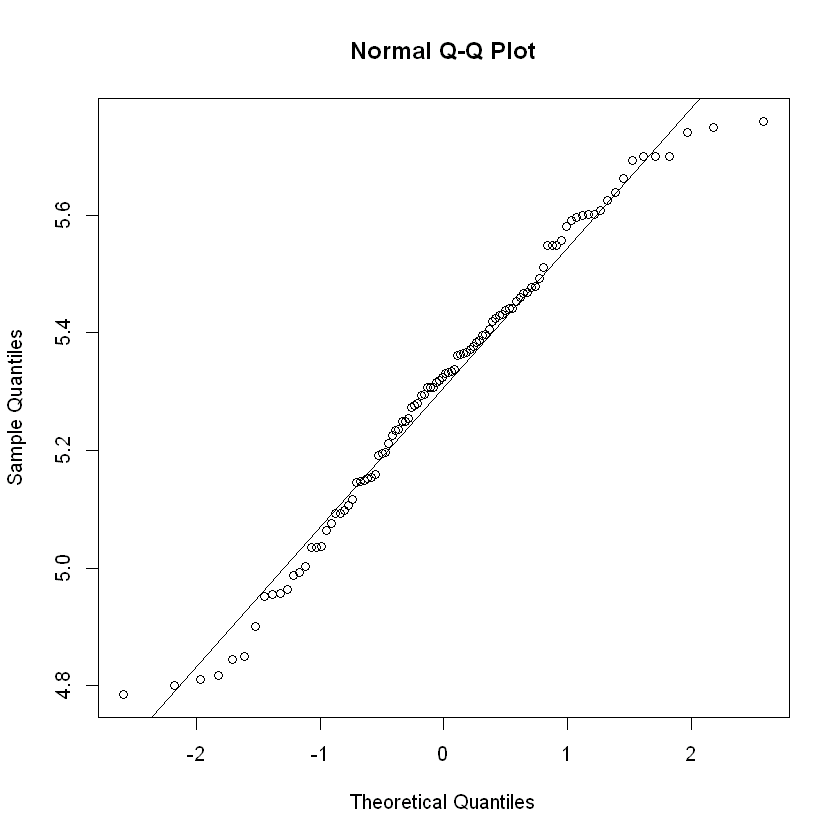

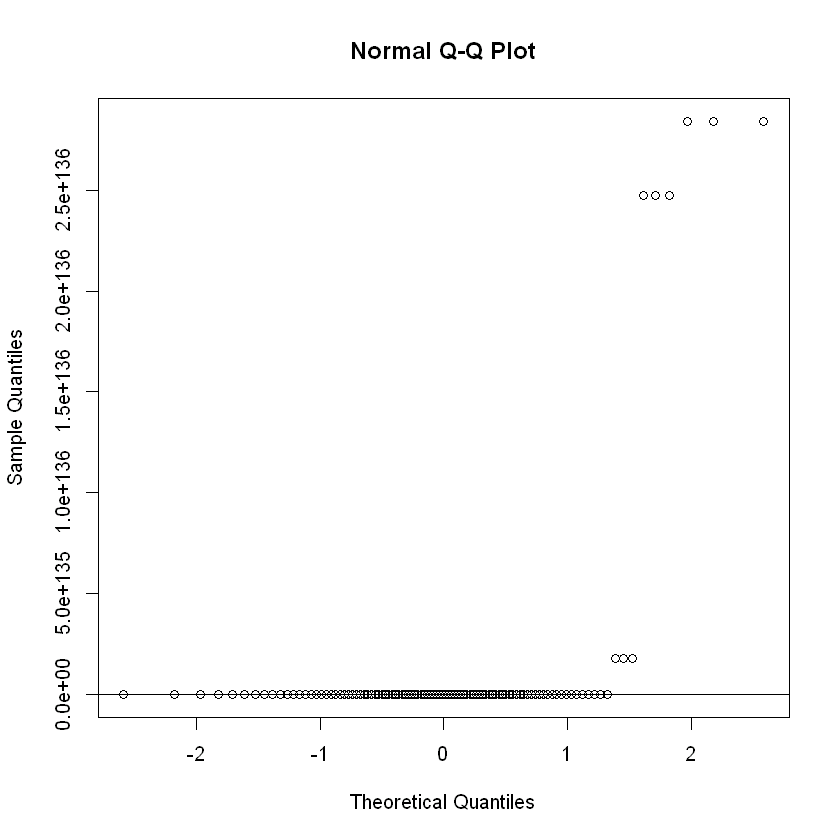

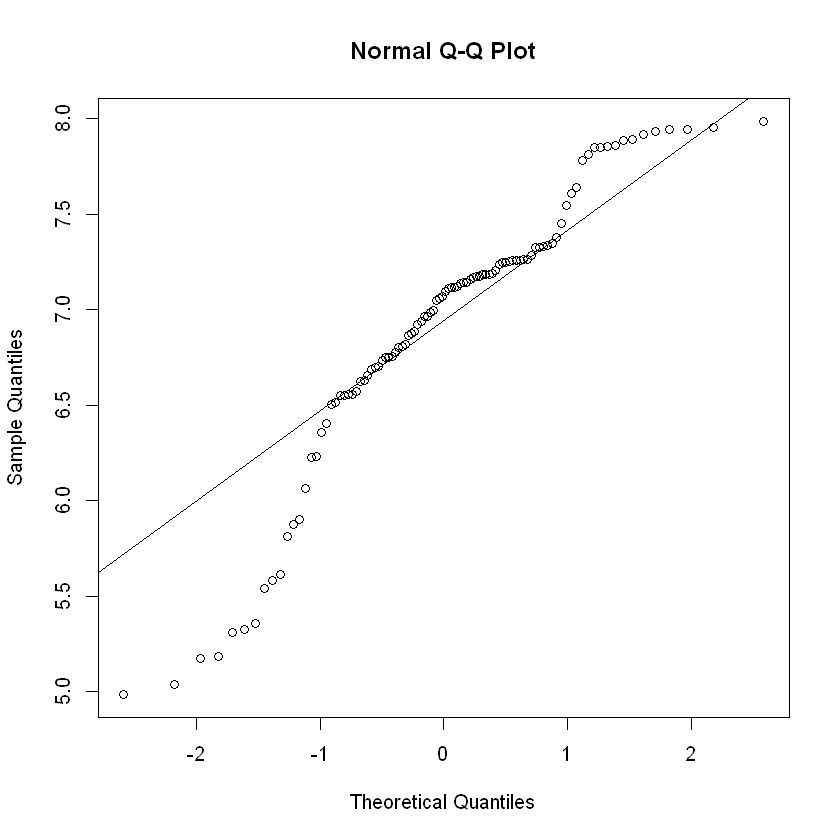

In [208]:
grund_df<-tdf%>%filter(examen=="Summed Doktorsgrad/Doktorsexamen")%>%mutate(kön=factor(kön,ordered=FALSE,levels=c("män","kvinnor","totalt")))
grund_df
qqnorm(log(grund_df$medelinkomst))
qqline(log(grund_df$medelinkomst))
qqnorm((exp(grund_df$AVG_KPI_skugg)))
qqline((exp(grund_df$AVG_KPI_skugg)))
qqnorm(log(grund_df$antal))
qqline(log(grund_df$antal))


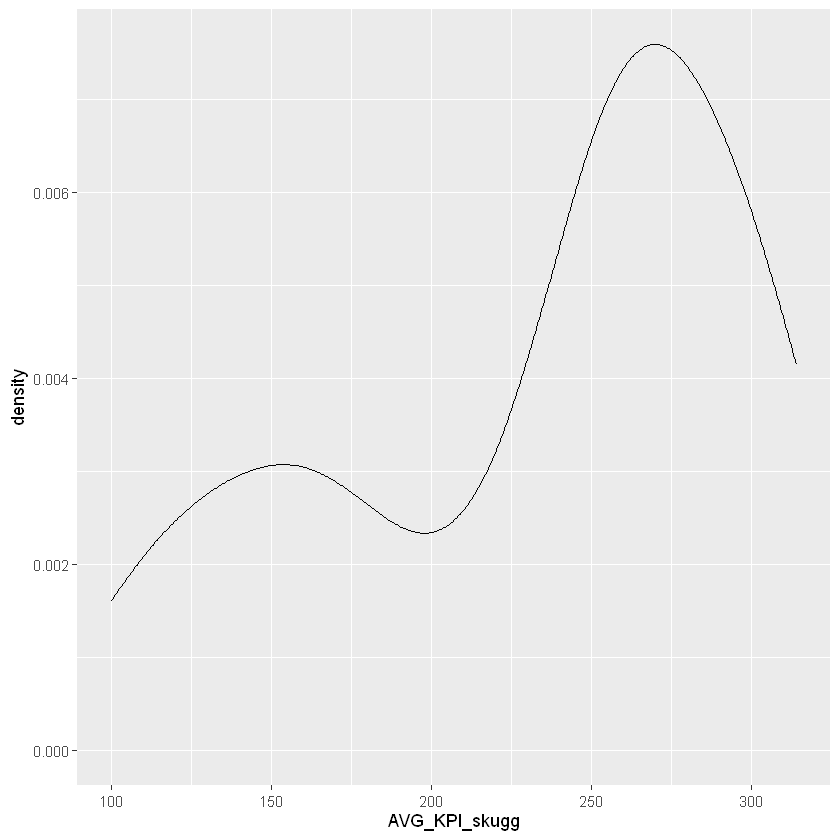

In [209]:
ggplot(data=grund_df)+geom_density(mapping = aes(x=AVG_KPI_skugg))#+geom_boxplot()#+facet_wrap(~år)

In [210]:
tmod<-lm(data=grund_df,antal~år+AVG_KPI_skugg+kön+medelinkomst+folkmängd_män+folkmängd_kvinnor+folkmängd_totalt)#
#lm.fit(y=grund_df%>%select(antal),x=grund_dfselect(!antal))
anova(tmod)
summary(tmod)

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
år,1,24388695.66,24388695.66,454.9647418,8.560409e-38
AVG_KPI_skugg,1,46317.31,46317.31,0.8640373,3.549923e-01
kön,2,21865622.18,10932811.09,203.9487327,6.428416e-35
medelinkomst,1,26212.07,26212.07,0.4889793,4.861097e-01
folkmängd_män,1,1178004.07,1178004.07,21.9753580,9.325309e-06
folkmängd_kvinnor,1,66551.10,66551.10,1.2414935,2.680243e-01
Residuals,94,5038934.19,53605.68,NA,NA



Call:
lm(formula = antal ~ år + AVG_KPI_skugg + kön + medelinkomst + 
    folkmängd_män + folkmängd_kvinnor + folkmängd_totalt, 
    data = grund_df)

Residuals:
    Min      1Q  Median      3Q     Max 
-469.57 -105.64   11.95  102.02  539.78 

Coefficients: (1 not defined because of singularities)
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)       -2.778e+05  5.138e+04  -5.406 4.86e-07 ***
år                 1.504e+02  2.687e+01   5.597 2.14e-07 ***
AVG_KPI_skugg     -1.488e+00  4.086e+00  -0.364 0.716601    
könkvinnor        -8.131e+02  2.496e+02  -3.258 0.001562 ** 
köntotalt          5.179e+02  1.330e+02   3.895 0.000184 ***
medelinkomst      -5.435e+00  3.116e+00  -1.744 0.084414 .  
folkmängd_män      3.047e-03  5.121e-03   0.595 0.553259    
folkmängd_kvinnor -7.402e-03  6.643e-03  -1.114 0.268024    
folkmängd_totalt          NA         NA      NA       NA    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard err